In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fastf1.plotting
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
from fastf1 import utils

For this project, I will be using the fastf1 library, which is built on top of Pandas DataFrames and Series but includes convenient methods for working specifically with Formula 1 data. The goal of this project is to analyze the race session of the 2024 Australian Grand Prix, where Ferrari achieved a 1-2 finish with Carlos Sainz as the winner (proud moment for a Ferrari fan!).

The first step is to load the data for this session. After loading the data, we will proceed with data cleaning. This involves removing laps affected by pit stops and laps that are not accurate due to yellow flags, virtual safety cars, safety cars, or red flags.


In [17]:
# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme = 'fastf1')


# load a session and its telemetry data
session = fastf1.get_session(2024, 'Austin Grand Prix', 'Q')
session.load()
# In this way i Can exclude the box laps
laps = session.laps

# Pick just the accurate laps

circuit_info = session.get_circuit_info()
pos = laps.pick_fastest().get_pos_data()




core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '55', '16', '81', '63', '10', '14', '20', '11', '22', '27', '31', '18', '30', '23', '43', '77', '44', '24']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core       

In [3]:
drivers =laps['Driver'].unique()
compounds = laps['Compound'].unique()


In [4]:
def timedelta_to_seconds(td: pd.Timedelta) -> float:
    """
    Convert a pandas Timedelta to a float representing the total seconds.
    
    Parameters:
    - td: pd.Timedelta
    
    Returns:
    - float: total seconds
    """
    return td.total_seconds()

In [5]:
# Transform the laps in total seconds
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()



# order the team from the fastest (lowest median lap time) to slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)

# make a color palette associating team names to hex codes

specific_color_kick_sauber = '#90EE90'  # Light green
specific_color_alpha_tauri = '#1634cb'  # Specific blue color

def get_team_color(team):
    if team == 'Kick Sauber' or team == 'Alfa Romeo':
        return specific_color_kick_sauber
    elif team == 'AlphaTauri':
        return specific_color_alpha_tauri
    else:
        try:
            return fastf1.plotting.team_color(team)
        except KeyError:
            return '#000000'  # Default color (black) if team is not recognized

team_palette = {team: get_team_color(team) for team in team_order}


/Users/PietroPaolo/opt/anaconda3/envs/progLab/lib/python3.9/site-packages/fastf1/plotting/_plotting.py:237: FutureWarning: The function `team_color` is deprecated and will be removed in a future version. Use `fastf1.plotting.get_team_color` instead.
  warnings.warn("The function `team_color` is deprecated and will be "
_plotting    WARNING 	Correcting invalid user input 'haas  ' to 'haas'.
_plotting    WARNING 	Correcting invalid user input 'red bull ' to 'red bull'.


In [6]:
colors = {
    "SAI": "red", "LEC": "red", "NOR": "orange", "PIA": "orange", "PER": "blue",
    "ALO": "green", "RUS": "grey", "STR": "green", "TSU": "#9932CC", "BOT": "lime",
    "OCO": "pink", "HUL": "olive", "MAG": "olive", "RIC": "#9932CC", "ALB": "navy",
    "ZHO": "lime", "GAS": "pink", "HAM": "grey", "VER": "blue", 'SAR':"navy", 'DEV': "#9932CC", 
    'BEA': "olive", 'LAW':  "#9932CC", 'MSC': "olive", 'LAT': "navy", 'VET' : "green", 'COL':"navy"
}

In [7]:
def interpolate_dataframe(df):
    # Creating a new DataFrame with interpolated data
    new_df = pd.DataFrame()

    for column in df.columns:
        # Interpolating each column
        original_data = df[column].to_numpy()
        interleaved_data = np.empty(2 * len(original_data) - 1, dtype=original_data.dtype)
        
        # Fill with original data in even indices
        interleaved_data[0::2] = original_data

        # Check the data type of the column
        if np.issubdtype(original_data.dtype, np.number):
            # Interpolated data for numerical columns
            interleaved_data[1::2] = (original_data[:-1] + original_data[1:]) / 2
        elif np.issubdtype(original_data.dtype, np.datetime64):
            # Interpolated data for datetime columns
            interleaved_data[1::2] = (original_data[:-1] + (original_data[1:] - original_data[:-1]) / 2)
        elif np.issubdtype(original_data.dtype, np.bool_):
            # For boolean columns, use logical interpolation (e.g., keep the previous value)
            interleaved_data[1::2] = original_data[:-1]
        else:
            # For any other types, fallback to forward fill
            interleaved_data[1::2] = original_data[:-1]

        # Assigning the new column to the new DataFrame
        new_df[column] = interleaved_data

    return new_df

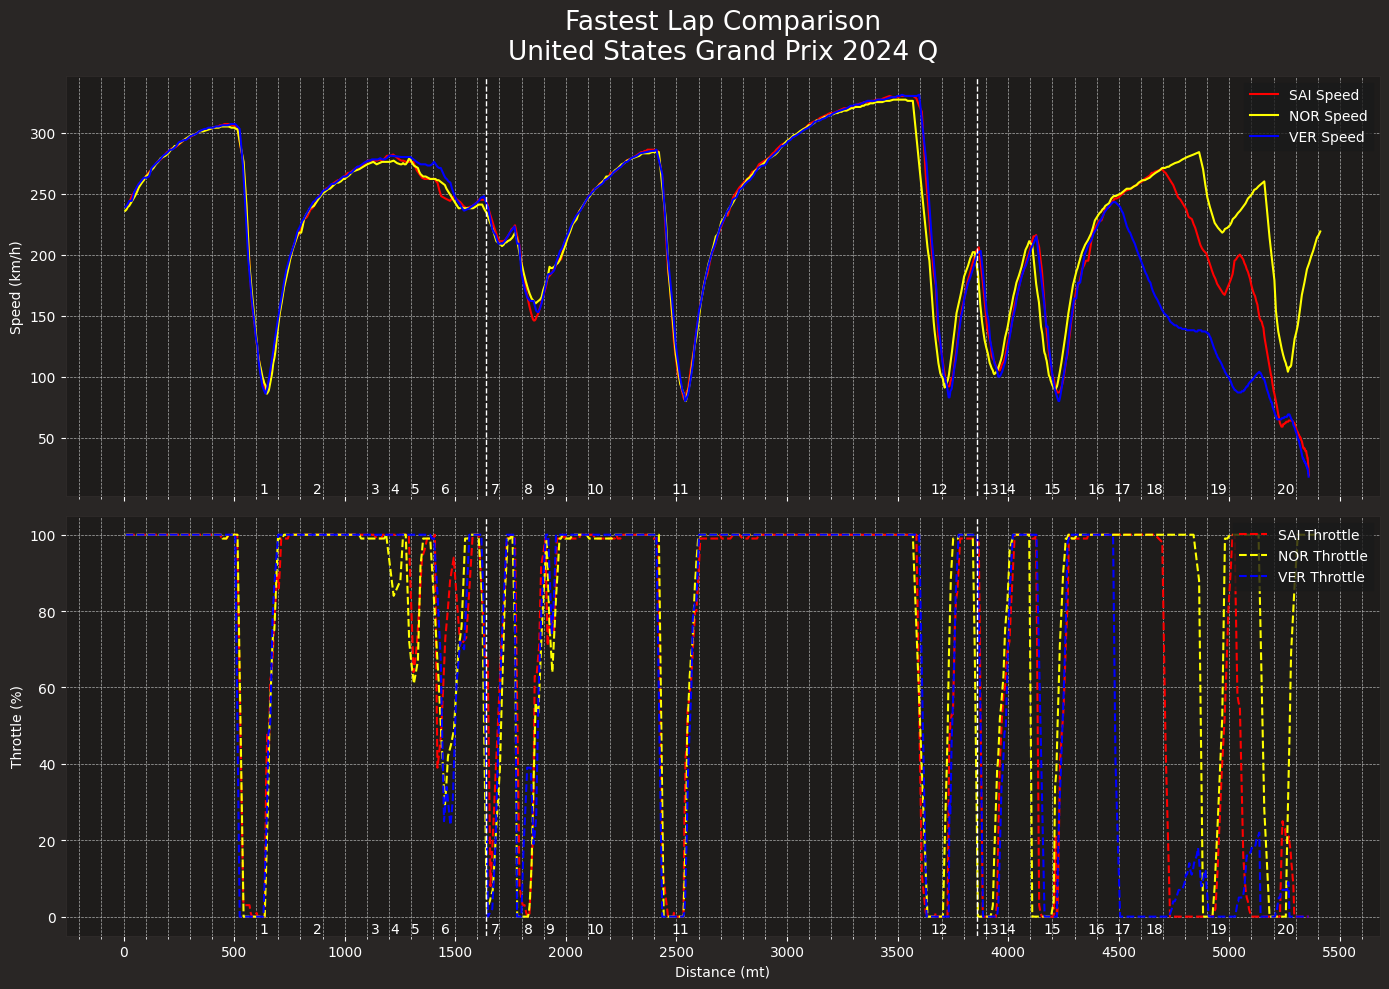

In [8]:
# Extract fastest laps for LEC and SAI
LEC_FASTEST_LAP = laps[laps['Driver']=='LEC'].loc[71]
SAI_FASTEST_LAP = laps[laps['Driver']=='SAI'].loc[51]
VER_FASTEST_LAP = laps[laps['Driver']=='VER'].loc[32]
NOR_FASTEST_LAP = transformed_laps.pick_drivers('NOR').pick_fastest()



# Get telemetry data and add distance
LEC_tel = LEC_FASTEST_LAP.get_car_data().add_distance()
SAI_tel = SAI_FASTEST_LAP.get_car_data().add_distance()
VER_tel = VER_FASTEST_LAP.get_car_data().add_distance()
NOR_tel = NOR_FASTEST_LAP.get_car_data().add_distance()

LEC_tel = interpolate_dataframe(LEC_tel)
SAI_tel = interpolate_dataframe(SAI_tel)
VER_tel = interpolate_dataframe(VER_tel)
NOR_tel = interpolate_dataframe(NOR_tel)

# Length of the track
length_circuit = LEC_tel['Distance'].max()

# Get sector times for the fastest lap
LEC_sector_times = [
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector1Time']),
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector2Time']),
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector3Time'])
]

# Calculate total lap time
total_lap_time = sum(LEC_sector_times)

# Calculate sector end distances
sector1_end_distance = LEC_tel[LEC_tel['Time'] <= LEC_FASTEST_LAP['Sector1Time']]['Distance'].max()
sector2_end_distance = LEC_tel[LEC_tel['Time'] <= (LEC_FASTEST_LAP['Sector1Time'] + LEC_FASTEST_LAP['Sector2Time'])]['Distance'].max()

# Extract the 'Distance' column from the corners DataFrame
corner_distances = circuit_info.corners['Distance']
# Generate corner numbers based on the number of corners
corner_numbers = range(1, len(corner_distances) + 1)  # Generates sequential numbers from 1 to the number of corners


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Apply a dark background
plt.style.use('dark_background')

# Plot Speed on the first subplot
ax1.plot(SAI_tel['Distance'], SAI_tel['Speed'], color='red', label='SAI Speed')
ax1.plot(NOR_tel['Distance'], NOR_tel['Speed'], color='yellow', label='NOR Speed')
ax1.plot(VER_tel['Distance'], VER_tel['Speed'], color='blue', label='VER Speed')
ax1.set_ylabel('Speed (km/h)', color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', colors='white')
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper right')
ax1.set_title(f"Fastest Lap Comparison\n{session.event['EventName']} {session.event.year} Q", color='white')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))

# Annotate with corner numbers on ax1
for corner, number in zip(corner_distances, corner_numbers):
    ax1.text(corner, ax1.get_ylim()[0], str(number), color='white', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
# Plot Throttle on the second subplot
ax2.plot(SAI_tel['Distance'], SAI_tel['Throttle'], color='red', linestyle='--', label='SAI Throttle')
ax2.plot(NOR_tel['Distance'], NOR_tel['Throttle'], color='yellow', linestyle='--', label='NOR Throttle')
ax2.plot(VER_tel['Distance'], VER_tel['Throttle'], color='blue', linestyle='--', label='VER Throttle')
ax2.set_xlabel('Distance (mt)', color='white')
ax2.set_ylabel('Throttle (%)', color='white')
ax2.tick_params(axis='y', colors='white')
ax2.tick_params(axis='x', colors='white')
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(100))

# Annotate with corner numbers on ax2
for corner, number in zip(corner_distances, corner_numbers):
    ax2.text(corner, ax2.get_ylim()[0], str(number), color='white', fontsize=10, verticalalignment='bottom', horizontalalignment='center')


# Add custom vertical dashed lines for sectors to both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=sector1_end_distance, color='white', linestyle='--', linewidth=1, label='End of Sector 1')
    ax.axvline(x=sector2_end_distance, color='white', linestyle='--', linewidth=1, label='End of Sector 2')

# Adjust layout
plt.tight_layout()
plt.show()


In [9]:
END_S2_VER = timedelta_to_seconds(VER_FASTEST_LAP['Sector1Time'] + VER_FASTEST_LAP['Sector2Time'])

END_S2_SAI = timedelta_to_seconds(SAI_FASTEST_LAP['Sector1Time'] + SAI_FASTEST_LAP['Sector2Time'])

END_S2_NOR = timedelta_to_seconds(NOR_FASTEST_LAP['Sector1Time'] + NOR_FASTEST_LAP['Sector2Time'])

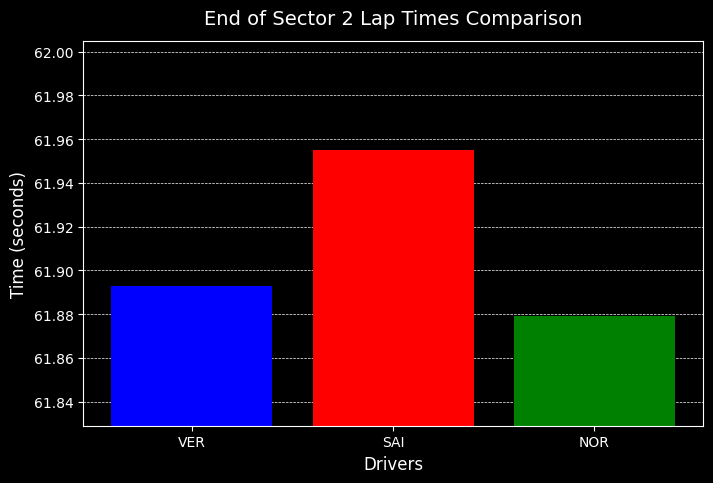

In [10]:
# Creating labels and data
drivers_plot = ['VER', 'SAI', 'NOR']

end_s2_times = [END_S2_VER, END_S2_SAI, END_S2_NOR]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(drivers_plot, end_s2_times, color=['blue', 'red', 'green'])

# Adding labels and title
plt.title('End of Sector 2 Lap Times Comparison', fontsize=14)
plt.xlabel('Drivers', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)

# Fine-tuning the y-axis to show slight differences
plt.ylim(min(end_s2_times) - 0.05, max(end_s2_times) + 0.05)  # Adjust the range

# Adding grid for better precision visibility
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Showing the plot
plt.show()

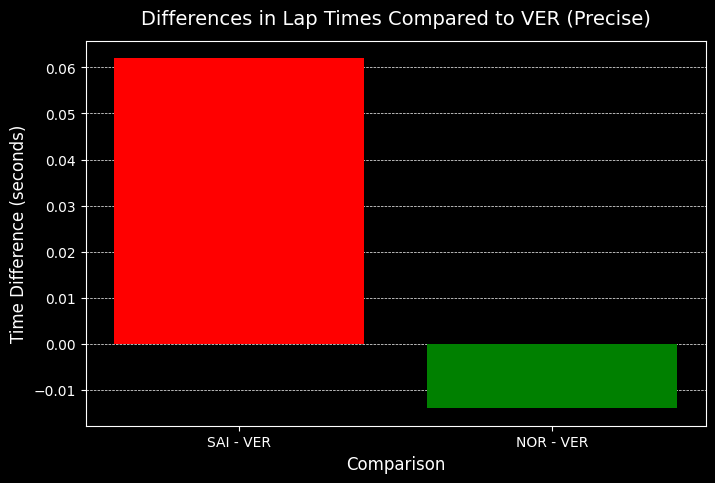

In [54]:
# Calculating the differences
diff_sai_ver = END_S2_SAI - END_S2_VER
diff_nor_ver = END_S2_NOR - END_S2_VER

# Data for the differences
diff_drivers = ['SAI - VER', 'NOR - VER']
diff_values = [diff_sai_ver, diff_nor_ver]

# Plotting the differences
plt.figure(figsize=(8, 5))
plt.bar(diff_drivers, diff_values, color=['red', 'green'])

# Adding labels and title
plt.title('Differences in Lap Times Compared to VER (Precise)', fontsize=14)
plt.xlabel('Comparison', fontsize=12)
plt.ylabel('Time Difference (seconds)', fontsize=12)

# Adding grid for better precision visibility
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Showing the plot
plt.show()

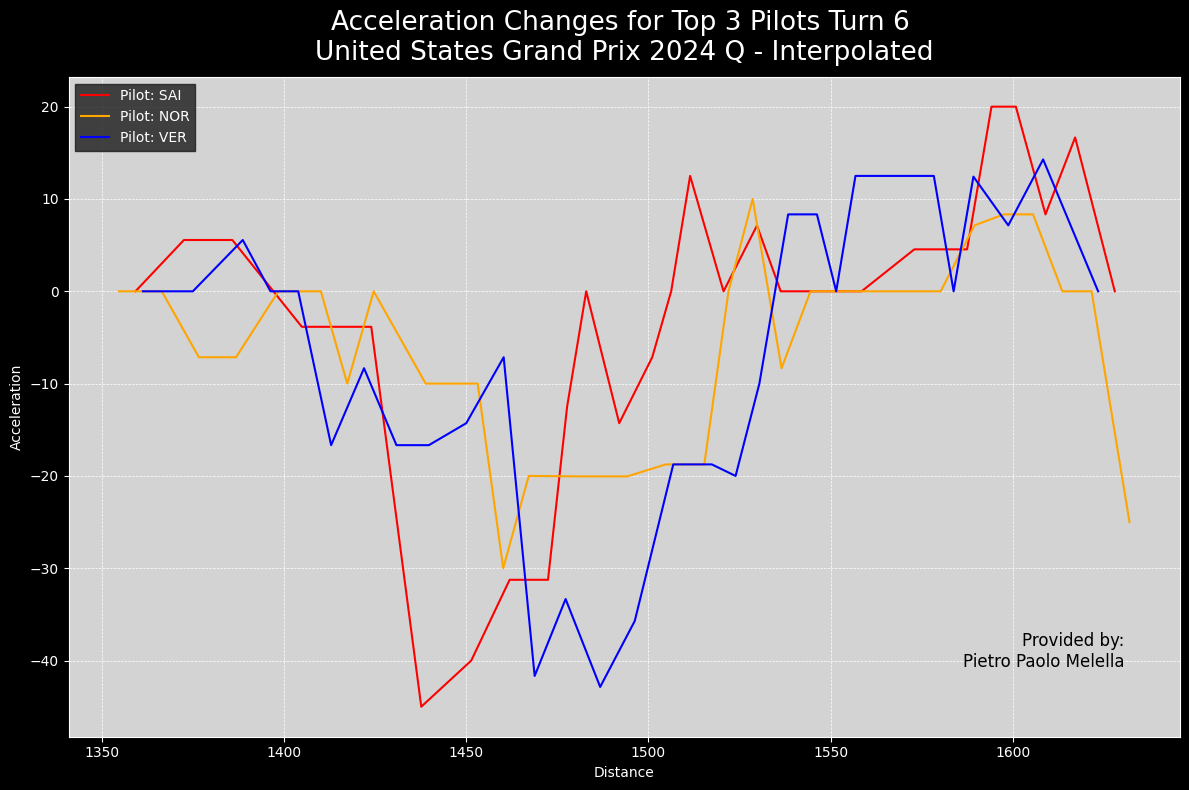

In [15]:
drivers =['SAI', 'NOR', 'VER']

# Initialize a figure for the plot
plt.figure(figsize=(12, 8))
# Set the background color of the plot (axes area)
plt.gca().set_facecolor('lightgray')

# Loop through each driver and plot their speed changes
for pilot in drivers:
    # Pick the fastest lap for each pilot
    fastest_laps_for_pilot = transformed_laps.pick_drivers(pilot).pick_fastest()
    
    # Get car data and add distance
    pilot_car_data = fastest_laps_for_pilot.get_car_data().add_distance()

    pilot_car_data = interpolate_dataframe(pilot_car_data)
    
    # Selecting the data starting for turn 6
    pilot_car_data_turn_6 = pilot_car_data[
        (pilot_car_data['Distance'] > (corner_distances[4] + 35)) & 
        (pilot_car_data['Distance'] < sector1_end_distance)
    ].copy()  # Ensure it's a copy to avoid SettingWithCopyWarning

    # Calculate acceleration
    pilot_car_data_turn_6.loc[:, 'Acceleration'] = (
        (pilot_car_data_turn_6['Speed'].diff().fillna(0)) /
        pilot_car_data_turn_6['SessionTime'].dt.total_seconds().diff().fillna(0)
    ).fillna(0)

    # Filter rows where throttle is less than 101 and reset index
    pilot_car_data_turn_6_throttle_99 = pilot_car_data_turn_6[
        pilot_car_data_turn_6['Throttle'] < 101
    ].reset_index()

    # Plot the speed vs. distance for the current pilot, using the color from the 'colors' dictionary
    plt.plot(pilot_car_data_turn_6_throttle_99['Distance'], 
             pilot_car_data_turn_6_throttle_99['Acceleration'], 
             color=colors.get(pilot, 'black'),  # Use pilot-specific color or default to 'black' if not found
             label=f"Pilot: {pilot}")

# Add a signature in the lower-right corner with a newline
plt.text(
    0.95, 0.1, 'Provided by:\nPietro Paolo Melella',
    verticalalignment='bottom', horizontalalignment='right',
    transform=plt.gca().transAxes,
    color='Black', fontsize=12
)

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Acceleration')
plt.title(f"Acceleration Changes for Top 3 Pilots Turn 6 \n{session.event['EventName']} {session.event.year} Q - Interpolated", color='white')
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

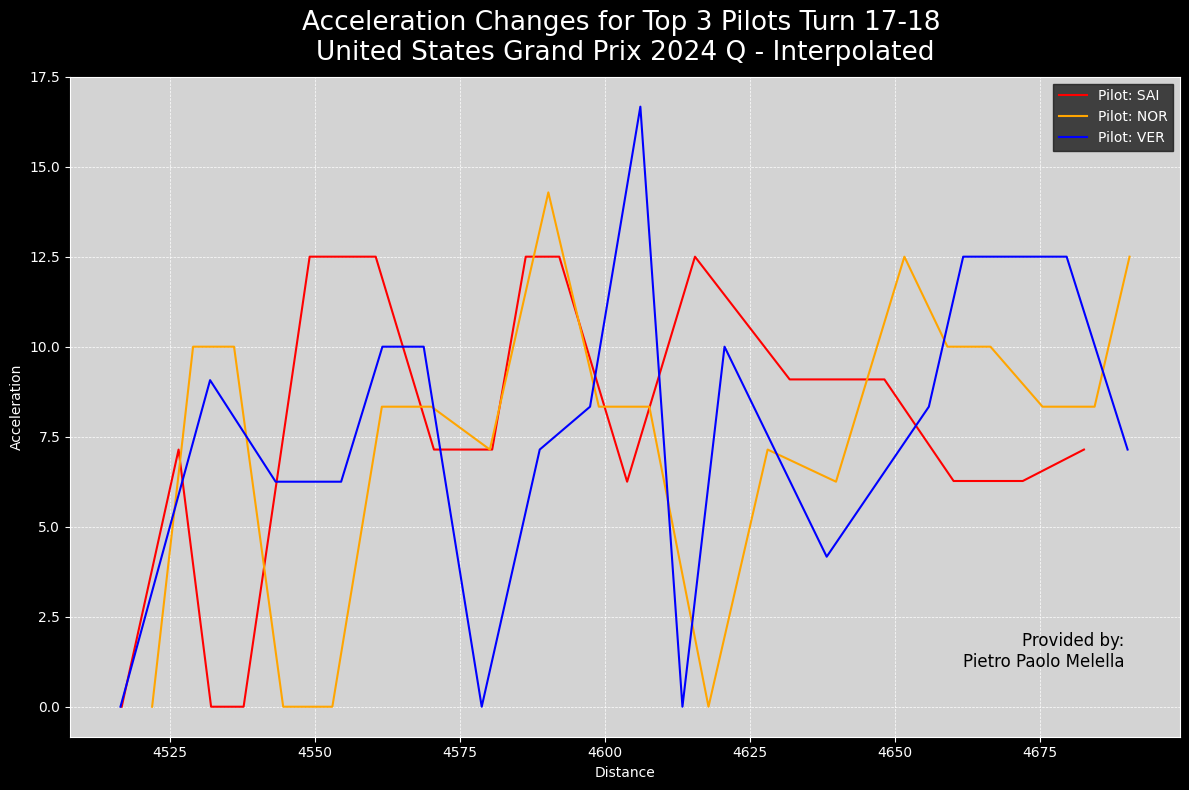

In [16]:
# Initialize a figure for the plot
plt.figure(figsize=(12, 8))
# Set the background color of the plot (axes area)
plt.gca().set_facecolor('lightgray')

# Loop through each driver and plot their speed changes
for pilot in drivers:
    # Pick the fastest lap for each pilot
    fastest_laps_for_pilot = transformed_laps.pick_drivers(pilot).pick_fastest()
    
    # Get car data and add distance
    pilot_car_data = fastest_laps_for_pilot.get_car_data().add_distance()

    pilot_car_data = interpolate_dataframe(pilot_car_data)
    
    # Selecting the data starting for turn 6
    pilot_car_data_turn_17_18 = pilot_car_data[
        (pilot_car_data['Distance'] > (corner_distances[16])) & 
        (pilot_car_data['Distance'] < corner_distances[17]+30)
    ].copy()  # Ensure it's a copy to avoid SettingWithCopyWarning

    # Calculate acceleration
    pilot_car_data_turn_17_18.loc[:, 'Acceleration'] = (
        (pilot_car_data_turn_17_18['Speed'].diff().fillna(0)) /
        pilot_car_data_turn_17_18['SessionTime'].dt.total_seconds().diff().fillna(0)
    ).fillna(0)

    # Filter rows where throttle is less than 99 and reset index
    pilot_car_data_turn_17_18_throttle_99 = pilot_car_data_turn_17_18[
        pilot_car_data_turn_17_18['Throttle'] < 101
    ].reset_index()

    # Plot the speed vs. distance for the current pilot, using the color from the 'colors' dictionary
    plt.plot(pilot_car_data_turn_17_18_throttle_99['Distance'], 
             pilot_car_data_turn_17_18_throttle_99['Acceleration'], 
             color=colors.get(pilot, 'black'),  # Use pilot-specific color or default to 'black' if not found
             label=f"Pilot: {pilot}")

# Add a signature in the lower-right corner with a newline
plt.text(
    0.95, 0.1, 'Provided by:\nPietro Paolo Melella',
    verticalalignment='bottom', horizontalalignment='right',
    transform=plt.gca().transAxes,
    color='Black', fontsize=12
)

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Acceleration')
plt.title(f"Acceleration Changes for Top 3 Pilots Turn 17-18 \n{session.event['EventName']} {session.event.year} Q - Interpolated", color='white')
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()